<a href="https://colab.research.google.com/github/XuRui314/MathematicalModeling/blob/main/Multivariate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# preparation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 降维技术一览
>参考原文：
>
>https://zhuanlan.zhihu.com/p/43225794
>
>https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

>sklearn教程：
>
>https://zhuanlan.zhihu.com/p/157616744
>
>https://cloud.tencent.com/developer/news/58202


数据维度的降低方法主要有两种：

1.  仅保留原始数据集中最相关的变量（特征选择）。
2.  寻找一组较小的新变量，其中每个变量都是输入变量的组合，包含与输入变量基本相同的信息（降维）。

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/08/Screenshot-from-2018-08-10-12-07-43.png)

- 缺失值比率：如果数据集的缺失值太多，我们可以用这种方法减少变量数。
- 低方差滤波：这个方法可以从数据集中识别和删除常量变量，方差小的变量对目标变量影响不大，所以可以放心删去。
- 高相关滤波：具有高相关性的一对变量会增加数据集中的多重共线性，所以用这种方法删去其中一个是有必要的。
- 随机森林：这是最常用的降维方法之一，它会明确算出数据集中每个特征的重要性。
- 前向特征选择和反向特征消除：这两种方法耗时较久，计算成本也都很高，所以只适用于输入变量较少的数据集。
- 因子分析：这种方法适合数据集中存在高度相关的变量集的情况。
- PCA：这是处理线性数据最广泛使用的技术之一。
- ICA：我们可以用ICA将数据转换为独立的分量，使用更少的分量来描述数据。
- ISOMAP：适合非线性数据处理。
- t-SNE：也适合非线性数据处理，相较上一种方法，这种方法的可视化更直接。
- UMAP：适用于高维数据，与t-SNE相比，这种方法速度更快。

## Feature Selection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [205]:
import os
os.chdir("/content/drive/MyDrive/dataset")
!ls

bbc-text.csv	    Fashion_MINST  ner.csv  train_LbELtWX.zip
Big-Mark-Sales.csv  MathModel	   train


In [ ]:
train=pd.read_csv("Big-Mark-Sales.csv")

In [ ]:
train[0:5]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**缺失值比率（Missing Value Ratio）**

假设你有一个数据集，你第一步会做什么？在构建模型前，对数据进行探索性分析必不可少。但在浏览数据的过程中，有时候我们会发现其中包含不少缺失值。如果缺失值少，我们可以填补缺失值或直接删除这个变量；如果缺失值过多，你会怎么办呢？

当缺失值在数据集中的占比过高时，一般我会选择直接删除这个变量，因为它包含的信息太少了。但具体删不删、怎么删需要视情况而定，我们可以设置一个阈值，如果缺失值占比高于阈值，删除它所在的列。阈值越高，降维方法越积极。

In [ ]:
train.isnull().sum()/len(train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [ ]:
# 保存变量中的缺失值
a = train.isnull().sum()/len(train)*100
# 保存列名
variables = train.columns
variable = [ ]
for i in range(0,12):
    if a[i]<=20:   #setting the threshold as 20%
        variable.append(variables[i])

In [ ]:
variable

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

**低方差滤波（Low Variance Filter）**

如果我们有一个数据集，其中某列的数值基本一致，也就是它的方差非常低，那么这个变量还有价值吗？和上一种方法的思路一致，我们通常认为低方差变量携带的信息量也很少，所以可以把它直接删除。

放到实践中，就是先计算所有变量的方差大小，然后删去其中最小的几个。需要注意的一点是：方差与数据范围相关的，因此在采用该方法前需要对数据做归一化处理。

放在示例中，我们先估算缺失值：

In [ ]:
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True) # 填充中位数
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True) # 填充众数

In [ ]:
train.isnull().sum()/len(train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

In [ ]:
train.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

In [ ]:
numeric = train[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']]
numeric

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,9.300,0.016047,249.8092,1999
1,5.920,0.019278,48.2692,2009
2,17.500,0.016760,141.6180,1999
3,19.200,0.000000,182.0950,1998
4,8.930,0.000000,53.8614,1987
...,...,...,...,...
8518,6.865,0.056783,214.5218,1987
8519,8.380,0.046982,108.1570,2002
8520,10.600,0.035186,85.1224,2004
8521,7.210,0.145221,103.1332,2009


In [ ]:
numeric.var()

Item_Weight                    17.869561
Item_Visibility                 0.002662
Item_MRP                     3878.183909
Outlet_Establishment_Year      70.086372
dtype: float64

In [ ]:
numeric = train[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']]
var = numeric.var()
numeric = numeric.columns
variable = [ ]
for i in range(0,len(var)):
    if var[i]>=10:   # 将阈值设置为10％
       variable.append(numeric[i])

In [ ]:
variable

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year']

**高相关滤波（High Correlation filter）**

如果两个变量之间是高度相关的，这意味着它们具有相似的趋势并且可能携带类似的信息。同理，这类变量的存在会降低某些模型的性能（例如线性和逻辑回归模型）。为了解决这个问题，我们可以计算独立数值变量之间的相关性。如果相关系数超过某个阈值，就删除其中一个变量。

作为一般准则，我们应该保留那些与目标变量显示相当或高相关性的变量。

首先，删除因变量（Item_Outlet_Sales），并将剩余的变量保存在新的数据列（df）中。

In [213]:
train=pd.read_csv("Big-Mark-Sales.csv")
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True) # 填充中位数
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True) # 填充众数
df=train.drop('Item_Outlet_Sales', 1)
df.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Weight,1.000000,-0.014168,0.024951,0.007739
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834
Item_MRP,0.024951,-0.001315,1.000000,0.005020
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000


如上表所示，示例数据集中不存在高相关变量，但通常情况下，如果一对变量之间的相关性大于0.5-0.6，那就应该考虑是否要删除一列了。



**随机森林（Random Forest）**

随机森林是一种广泛使用的特征选择算法，它会自动计算各个特征的重要性，所以无需单独编程。这有助于我们选择较小的特征子集。

在开始降维前，我们先把数据转换成数字格式，因为随机森林只接受数字输入。同时，ID这个变量虽然是数字，但它目前并不重要，所以可以删去。

详细资料：https://blog.csdn.net/zjuPeco/article/details/77371645

![](https://img-blog.csdnimg.cn/img_convert/7566a92f08ede082a296a9604c4a0af7.png#pic_center)

In [214]:
from sklearn.ensemble import RandomForestRegressor
df=df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
model = RandomForestRegressor(random_state=1, max_depth=10)
df=pd.get_dummies(df) # get_dummies 是利用pandas实现one hot encode的方式，教程：https://www.datalearner.com/blog/1051637141445141
model.fit(df,train.Item_Outlet_Sales)

RandomForestRegressor(max_depth=10, random_state=1)

In [215]:
df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object

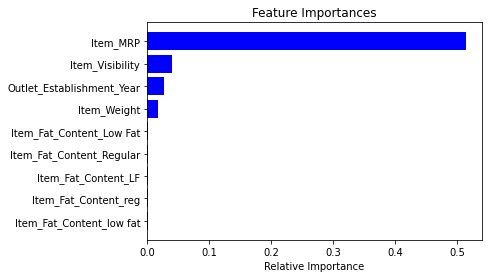

In [ ]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:9])  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

基于上图，我们可以手动选择最顶层的特征来减少数据集中的维度。如果你用的是sklearn，可以直接使用SelectFromModel，它根据权重的重要性选择特征。

In [ ]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
Fit = feature.fit_transform(df, train.Item_Outlet_Sales)

**反向特征消除（Backward Feature Elimination）**

以下是反向特征消除的主要步骤：

先获取数据集中的全部n个变量，然后用它们训练一个模型。
计算模型的性能。
在删除每个变量（n次）后计算模型的性能，即我们每次都去掉一个变量，用剩余的n-1个变量训练模型。
确定对模型性能影响最小的变量，把它删除。
重复此过程，直到不再能删除任何变量。

在构建线性回归或Logistic回归模型时，可以使用这种方法。

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selector.support_

array([ True,  True,  True,  True,  True, False, False, False, False,
       False])

In [ ]:
selector.ranking_

array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

我们需要指定算法和要选择的特征数量，然后返回反向特征消除输出的变量列表。此外，rfe.ranking_可以用来检查变量排名。

In [164]:
'''
DIMENSIONALITY REDUCTION - BACKWARD FEATURE ELIMINATION
'''

# importing required libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# read the data
train = pd.read_csv('Big-Mark-Sales.csv')


train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True) # 填充中位数
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True) # 填充众数
train=train.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1) # 这两个特征去掉的原因是：1.它们不是数值型 2.不同类型的值很多，不宜用dummies方法（用了以后就变成1k6列了）
train = pd.get_dummies(train)

print(train.head())
print(train.size)

# seperate the target and independent variable
X = train.drop(columns = ['Item_Outlet_Sales'],axis=1)
Y = train['Item_Outlet_Sales']


# create the object of the model
lreg = LinearRegression()


# specify the number of  features to select 
rfe = RFE(lreg, step = 10)

# fit the model
rfe = rfe.fit(X, Y)

print('\n\nFEATUERS SELECTED\n\n')
print(rfe.support_)

print('\n\nRANKING OF FEATURES\n\n')
print(rfe.ranking_)

   Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0         9.30         0.016047  249.8092                       1999   
1         5.92         0.019278   48.2692                       2009   
2        17.50         0.016760  141.6180                       1999   
3        19.20         0.000000  182.0950                       1998   
4         8.93         0.000000   53.8614                       1987   

   Item_Outlet_Sales  Item_Fat_Content_LF  Item_Fat_Content_Low Fat  \
0          3735.1380                    0                         1   
1           443.4228                    0                         0   
2          2097.2700                    0                         1   
3           732.3800                    0                         0   
4           994.7052                    0                         1   

   Item_Fat_Content_Regular  Item_Fat_Content_low fat  Item_Fat_Content_reg  \
0                         0                         0        

**前向特征选择（Forward Feature Selection）**

前向特征选择其实就是反向特征消除的相反过程，即找到能改善模型性能的最佳特征，而不是删除弱影响特征。它背后的思路如下所述：

选择一个特征，用每个特征训练模型n次，得到n个模型。
选择模型性能最佳的变量作为初始变量。
每次添加一个变量继续训练，重复上一过程，最后保留性能提升最大的变量。
一直添加，一直筛选，直到模型性能不再有明显提高。

In [ ]:
from sklearn.feature_selection import f_regression
ffs = f_regression(df,train.Item_Outlet_Sales )

上述代码会返回一个数组，其中包括变量[F值](https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/)和每个F对应的p值，我们选择F值大于10的变量：

In [ ]:
variable = [ ]
for i in range(0,len(df.columns)-1):
    if ffs[0][i] >=10:
       variable.append(df.columns[i])

[注]：*前向特征选择和反向特征消除耗时较久，计算成本也都很高，所以只适用于输入变量较少的数据集*

**PCA**

PCA也能用来选特征，也就是主因子。下面是一个案例：

对重庆市城镇居民人均消费数据的分析，消费包括视频、衣着、家庭设备用品、医疗保险、交通通信、文教娱乐、居住、杂项商品、服务这8个方面，给定的是从1997年到2006年这10年的数据。

In [189]:
import os
os.chdir("/content/drive/MyDrive/dataset/MathModel/PCA")
!ls

data12_1.txt  data12_2.txt  data12_3.xlsx  data12_5_1.txt  data12_5_2.xlsx


In [190]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [191]:
data = np.loadtxt('data12_1.txt') # 纯数据文件，可以采用np.loadtxt
print(data)

[[2297.86  589.62  474.74  164.19  290.91  626.21  295.2   199.03]
 [2262.19  571.69  461.25  185.9   337.83  604.78  354.66  198.96]
 [2303.29  589.99  516.21  236.55  403.92  730.05  438.41  225.8 ]
 [2308.7   551.14  476.45  293.23  406.44  785.74  494.04  254.1 ]
 [2337.65  589.28  509.82  334.05  442.5   850.15  563.72  246.51]
 [2418.96  618.6   454.2   429.6   615.   1065.12  594.48  164.28]
 [2702.34  735.01  475.36  459.69  790.26 1025.99  741.6   187.81]
 [3015.32  779.68  474.15  537.95  865.45 1200.52  903.22  196.77]
 [3135.65  849.53  583.5   629.32  929.92 1391.11  882.41  221.85]
 [3415.92 1038.98  615.74  705.72  976.02 1449.49  954.56  242.26]]


In [192]:
data = pd.read_csv('data12_1.txt',sep='\t', header=None) # 也可以用pandas来读txt

In [193]:
data

,0,1,2,3,4,5,6,7
0,2297.86,589.62,474.74,164.19,290.91,626.21,295.20,199.03
1,2262.19,571.69,461.25,185.90,337.83,604.78,354.66,198.96
2,2303.29,589.99,516.21,236.55,403.92,730.05,438.41,225.80
3,2308.70,551.14,476.45,293.23,406.44,785.74,494.04,254.10
4,2337.65,589.28,509.82,334.05,442.50,850.15,563.72,246.51
5,2418.96,618.60,454.20,429.60,615.00,1065.12,594.48,164.28
6,2702.34,735.01,475.36,459.69,790.26,1025.99,741.60,187.81
7,3015.32,779.68,474.15,537.95,865.45,1200.52,903.22,196.77
8,3135.65,849.53,583.50,629.32,929.92,1391.11,882.41,221.85
9,3415.92,1038.98,615.74,705.72,976.02,1449.49,954.56,242.26


In [194]:
data = data.values
print(data)

[[2297.86  589.62  474.74  164.19  290.91  626.21  295.2   199.03]
 [2262.19  571.69  461.25  185.9   337.83  604.78  354.66  198.96]
 [2303.29  589.99  516.21  236.55  403.92  730.05  438.41  225.8 ]
 [2308.7   551.14  476.45  293.23  406.44  785.74  494.04  254.1 ]
 [2337.65  589.28  509.82  334.05  442.5   850.15  563.72  246.51]
 [2418.96  618.6   454.2   429.6   615.   1065.12  594.48  164.28]
 [2702.34  735.01  475.36  459.69  790.26 1025.99  741.6   187.81]
 [3015.32  779.68  474.15  537.95  865.45 1200.52  903.22  196.77]
 [3135.65  849.53  583.5   629.32  929.92 1391.11  882.41  221.85]
 [3415.92 1038.98  615.74  705.72  976.02 1449.49  954.56  242.26]]


In [195]:
norm = zscore(data, ddof=1) # 数据标准化
print(norm)

[[-0.76076777 -0.64214522 -0.54059347 -1.25096611 -1.19811321 -1.14171193
  -1.38154326 -0.507142  ]
 [-0.84506173 -0.75532164 -0.78862442 -1.13462085 -1.01960322 -1.21228148
  -1.13035357 -0.50955582]
 [-0.7479358  -0.63980973  0.22188565 -0.8631843  -0.76815981 -0.79976409
  -0.77655041  0.41596886]
 [-0.7351511  -0.88503583 -0.50915293 -0.5594326  -0.75857232 -0.61637547
  -0.54154062  1.39183877]
 [-0.66673758 -0.64429134  0.10439731 -0.34067564 -0.62137986 -0.40427165
  -0.24717639  1.13011253]
 [-0.47458894 -0.4592198  -0.91824771  0.17138284  0.03490684  0.30363019
  -0.1172303  -1.70542749]
 [ 0.19508369  0.2755748  -0.52919398  0.33263705  0.70169414  0.17477407
   0.5042804  -0.89404166]
 [ 0.93470589  0.55753748 -0.55144138  0.75203733  0.98775905  0.74950593
   1.18704657 -0.58507366]
 [ 1.21906508  0.99843949  1.45909859  1.24169493  1.23303908  1.37712379
   1.09913441  0.27976087]
 [ 1.88138828  2.1942718   2.05187233  1.65112735  1.40842932  1.56937065
   1.40393319  0.

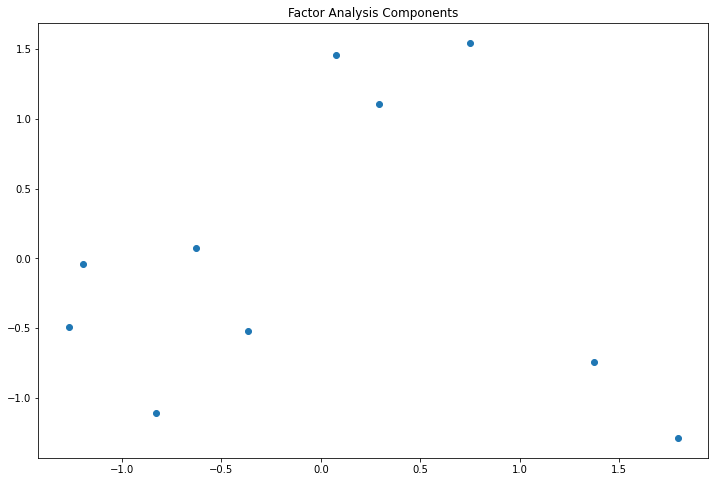

In [227]:
FA = FactorAnalysis(n_components = 2).fit_transform(norm) # df本身还包括个label的列
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])

In [196]:
model = PCA().fit(norm) # 构造并拟合模型
print('特征值是：\n', model.explained_variance_)
print('各主成分贡献率：\n', model.explained_variance_ratio_)

特征值是：
 [6.27943341e+00 1.30599080e+00 2.74277611e-01 9.97624700e-02
 2.31016993e-02 1.22233669e-02 4.69357480e-03 5.17066158e-04]
各主成分贡献率：
 [7.84929176e-01 1.63248850e-01 3.42847014e-02 1.24703088e-02
 2.88771241e-03 1.52792086e-03 5.86696851e-04 6.46332697e-05]


In [ ]:
xs1 = model.components_
print('各主成分系数：\n',xs1) # 就是协方差矩阵特征向量矩阵

各主成分系数：
 [[ 0.39186166  0.38439344  0.3059243   0.39231584  0.38537825  0.38961322
   0.38389911  0.05908768]
 [ 0.0210478  -0.02214509 -0.47783697  0.08905605  0.19878256  0.1043221
   0.11376475 -0.83634169]
 [-0.14762176 -0.39254883 -0.57745685  0.20021017  0.15914777  0.1347164
   0.4303164   0.47108809]
 [-0.47832186 -0.48941314  0.44488132  0.27708115 -0.02393188  0.46564673
  -0.07989617 -0.18222681]
 [-0.09762149 -0.27604773  0.34873203 -0.35508891  0.52307577 -0.45643408
   0.4158212  -0.10824944]
 [-0.70552867  0.53549607 -0.049896    0.32914209  0.14716623 -0.28505603
   0.02367193  0.03426265]
 [-0.08102349  0.10492282  0.11905975 -0.07206231 -0.68369188 -0.02060535
   0.68706375 -0.15212634]
 [ 0.28557308 -0.29011082  0.09180137  0.6940343  -0.15286467 -0.55886444
  -0.05098258 -0.07665729]]


In [ ]:
check = xs1.sum(axis = 1, keepdims=True) # 计算各个主成分系数和
xs2 = xs1*np.sign(check) # 和为负数的话就乘以-1
print('调整后的主成分系数：\n',xs2)

调整后的主成分系数：
 [[ 0.39186166  0.38439344  0.3059243   0.39231584  0.38537825  0.38961322
   0.38389911  0.05908768]
 [-0.0210478   0.02214509  0.47783697 -0.08905605 -0.19878256 -0.1043221
  -0.11376475  0.83634169]
 [-0.14762176 -0.39254883 -0.57745685  0.20021017  0.15914777  0.1347164
   0.4303164   0.47108809]
 [ 0.47832186  0.48941314 -0.44488132 -0.27708115  0.02393188 -0.46564673
   0.07989617  0.18222681]
 [ 0.09762149  0.27604773 -0.34873203  0.35508891 -0.52307577  0.45643408
  -0.4158212   0.10824944]
 [-0.70552867  0.53549607 -0.049896    0.32914209  0.14716623 -0.28505603
   0.02367193  0.03426265]
 [ 0.08102349 -0.10492282 -0.11905975  0.07206231  0.68369188  0.02060535
  -0.68706375  0.15212634]
 [-0.28557308  0.29011082 -0.09180137 -0.6940343   0.15286467  0.55886444
   0.05098258  0.07665729]]


## Dimensional Reduciton



到目前为止，我们介绍的6种方法都能很好地解决示例的商场销售预测问题，因为这个数据集本身输入变量不多。在下文中，为了展示多变量数据集的降维方法，我们将把数据集改成Fashion MNIST，它共有70,000张图像，其中训练集60,000张，测试集10,000张。我们的目标是训练一个能分类各类服装配饰的模型。

In [ ]:
# 下数据集
# !wget https://datahack-prod.s3.amazonaws.com/train_zip/train_LbELtWX.zip
# !unzip train_LbELtWX.zip -d ./Fashion_MINST

**因子分析（Factor Analysis）**

因子分析是一种常见的统计方法，它能从多个变量中提取共性因子，并得到最优解。假设我们有两个变量：收入和教育。它们可能是高度相关的，因为总体来看，学历高的人一般收入也更高，反之亦然。所以它们可能存在一个潜在的共性因子，比如“能力”。

在因子分析中，我们将变量按其相关性分组，即特定组内所有变量的相关性较高，组间变量的相关性较低。我们把每个组称为一个因子，它是多个变量的组合。和原始数据集的变量相比，这些因子在数量上更少，但携带的信息基本一致。:)

In [216]:
import os
os.chdir("/content/drive/MyDrive/dataset/Fashion_MINST")
!ls

train  train.csv


In [217]:
import pandas as pd
import numpy as np
from glob import glob
import cv2
images = [cv2.imread(file) for file in glob('train/*.png')]

现在我们先把这些图像转换为numpy数组格式，以便执行数学运算并绘制图像。



In [218]:
images = np.array(images)
images.shape

(60000, 28, 28, 3)

如上所示，这是一个三维数组，但我们的目标是把它转成一维，因为后续只接受一维输入。所以我们还得展平图像：



In [219]:
image = []
for i in range(0,60000):
    img = images[i].flatten()
    image.append(img)
image = np.array(image)

创建一个数据框，其中包含每个像素的像素值，以及它们对应的标签：



In [220]:
train = pd.read_csv("train.csv")     # Give the complete path of your train.csv file
feat_cols = [ 'pixel'+str(i) for i in range(image.shape[1]) ]
df = pd.DataFrame(image,columns=feat_cols)
df['label'] = train['label']

In [200]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
59998,0,0,0,0,0,0,0,0,0,0,...,193,193,193,202,202,202,76,76,76,0


用因子分析分解数据集：

In [224]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components = 3).fit_transform(df[feat_cols].values) # df本身还包括个label的列

In [225]:
FA.shape

(60000, 3)

这里，`n_components`将决定转换数据中的因子数量。转换完成后，可视化结果：


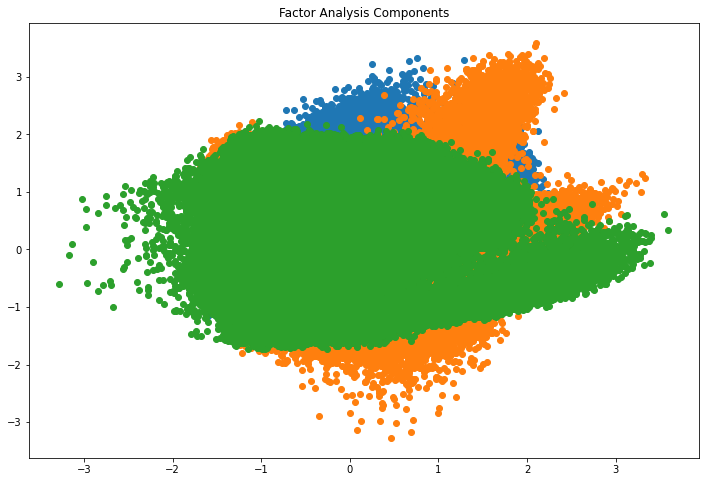

In [226]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

**奇异值分解(SVD)**

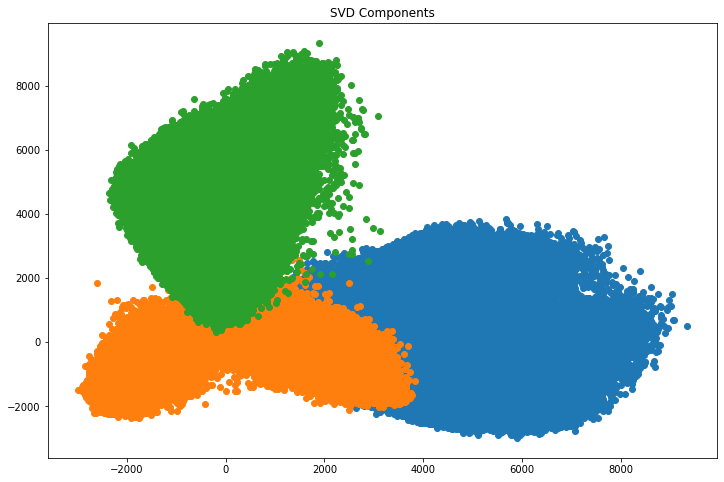

In [176]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(df[feat_cols].values)
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

**主成分分析（PCA）**

如果说因子分析是假设存在一系列潜在因子，能反映变量携带的信息，那PCA就是通过正交变换将原始的n维数据集变换到一个新的被称做主成分的数据集中，即从现有的大量变量中提取一组新的变量。下面是关于PCA的一些要点：

主成分是原始变量的线性组合。
- 第一个主成分具有最大的方差值。
- 第二主成分试图解释数据集中的剩余方差，并且与第一主成分不相关（正交）。
- 第三主成分试图解释前两个主成分等没有解释的方差。

再进一步降维前，我们先随机绘制数据集中的某些图：

<Figure size 432x288 with 0 Axes>

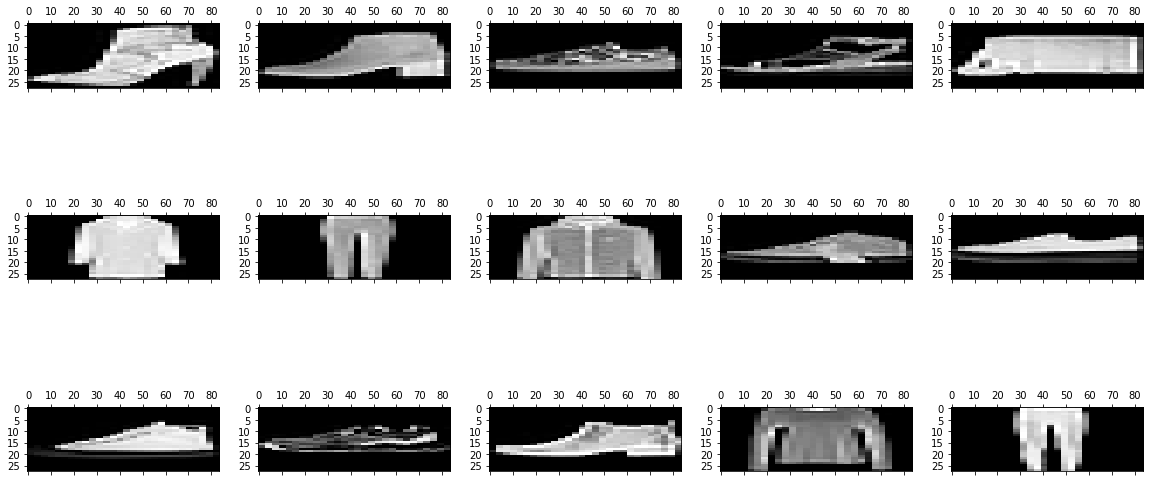

In [198]:
rndperm = np.random.permutation(df.shape[0])
plt.gray()
fig = plt.figure(figsize=(20,10))
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28*3)).astype(float))

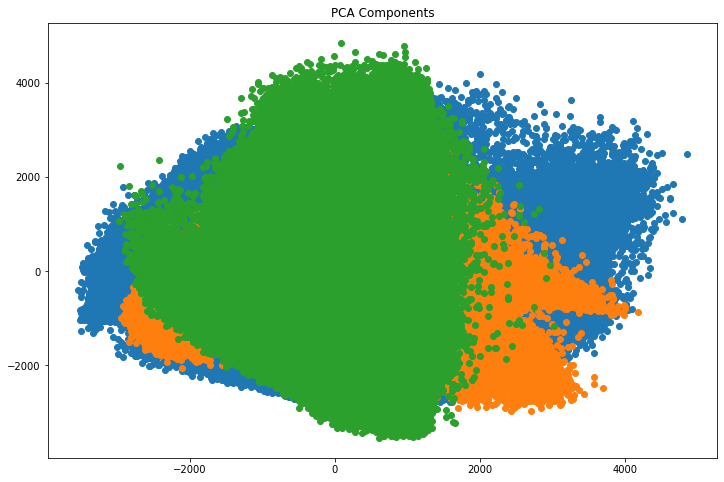

In [199]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[feat_cols].values)
plt.figure(figsize=(12,8))
plt.title('PCA Components')
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.scatter(pca_result[:,1], pca_result[:,2])
plt.scatter(pca_result[:,2], pca_result[:,0])

其中`n_components`将决定转换数据中的主成分。接下来，我们看一下这四个主成分解释了多少方差：

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

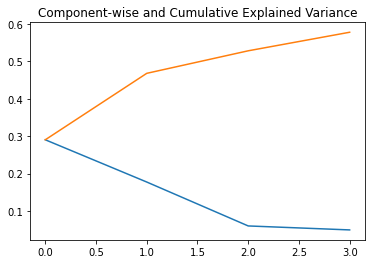

In [174]:
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

在上图中，蓝线表示分量解释的方差，而橙线表示累积解释的方差。我们只用四个成分就解释了数据集中约60％的方差。

**独立分量分析（ICA）**

独立分量分析（ICA）基于信息理论，是最广泛使用的降维技术之一。PCA和ICA之间的主要区别在于，PCA寻找不相关(uncorrelated)的因素，而ICA寻找独立(independent)因素。

如果两个变量不相关，它们之间就没有线性关系。如果它们是独立的，它们就不依赖于其他变量。例如，一个人的年龄和他吃了什么/看了什么电视无关。

该算法假设给定变量是一些未知潜在变量的线性混合。它还假设这些潜在变量是相互独立的，即它们不依赖于其他变量，因此它们被称为观察数据的独立分量。

下图是ICA和PCA的一个直观比较：

![](https://pic1.zhimg.com/v2-1c752ac5d6333cb948845dddc99e14bc_r.jpg)

PCA的等式是x = Wχ。

这里，

x是观察结果
W是混合矩阵
χ是来源或独立分量
现在我们必须找到一个非混合矩阵，使分量尽可能独立。而测试分量独立性最常用的方法是非高斯性：

- 根据中心极限定理（Central Limit Theorem），多个独立随机变量混合之后会趋向于正态分布（高斯分布）。

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/08/Screenshot-from-2018-08-09-19-48-16.png)

- 因此，我们可以寻找所有独立分量中能最大化峰度的分量。
- 一旦峰度被最大化，整个分布会呈现非高斯分布，我们也能得到独立分量。

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/08/Screenshot-from-2018-07-27-16-12-04.png)


In [175]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=3, random_state=12) 
X=ICA.fit_transform(df[feat_cols].values)

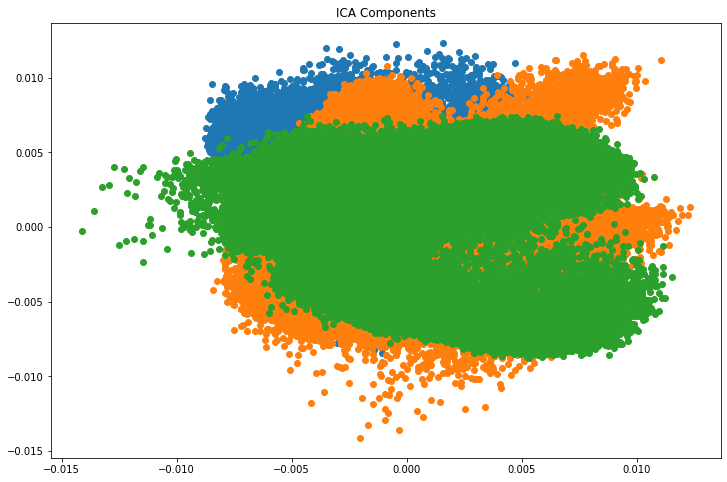

In [177]:
plt.figure(figsize=(12,8))
plt.title('ICA Components')
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,1], X[:,2])
plt.scatter(X[:,2], X[:,0])

**IOSMAP**

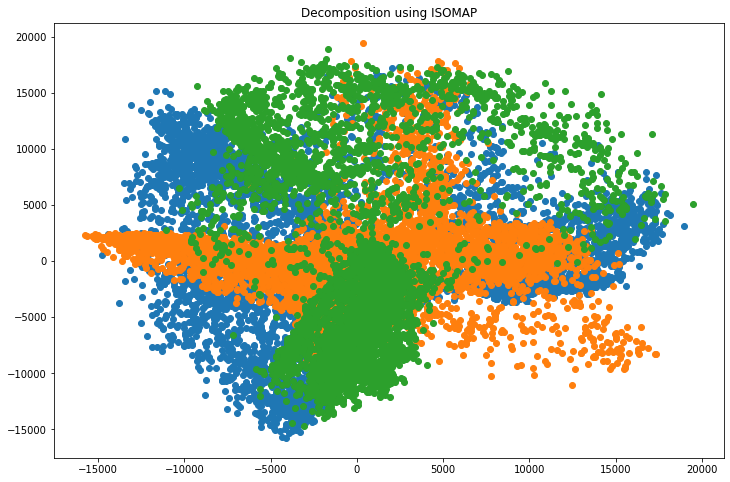

In [178]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(df[feat_cols][:6000].values)
plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

**t-SNE**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


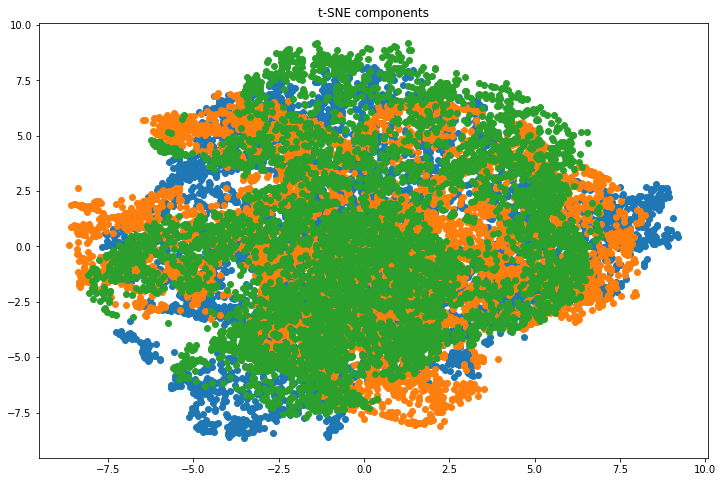

In [179]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3, n_iter=300).fit_transform(df[feat_cols][:6000].values)
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,2])
plt.scatter(tsne[:,2], tsne[:,0])

**UMAP**

In [186]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 18.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=2612e6b146721563861d4af3a990d3d3d300f207abc088fdb8753a32b5ea8f5a
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=ec3681bb0899daf527a557e4f2e7df8d53f78e7f0d2b4b4b1edaa5ca9e901115
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


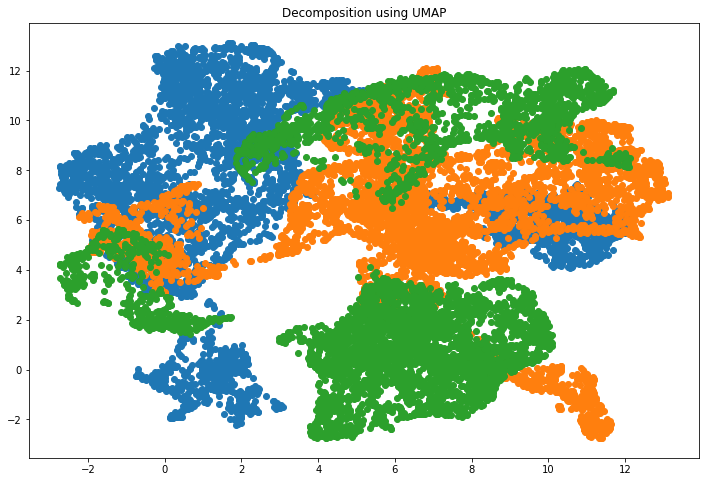

In [188]:
import umap.umap_ as umap
umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform(df[feat_cols][:6000].values)
plt.figure(figsize=(12,8))
plt.title('Decomposition using UMAP')
plt.scatter(umap_data[:,0], umap_data[:,1])
plt.scatter(umap_data[:,1], umap_data[:,2])
plt.scatter(umap_data[:,2], umap_data[:,0])